## In this notebook, we scale the Cosine with (1-lambda)  

In [1]:
#installing some libraries
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig,AutoModelForCausalLM, AutoConfig


import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch import cuda
import datetime
import warnings,itertools
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import autocast, GradScaler
import json,math
pre_train = False

# Ignore all warnings
warnings.filterwarnings('ignore')
#pip install transformers bitsandbytes>=0.39.0 -q
import zipfile,logging

In [3]:
#global params for training

B,T = 64,1024
epoch = 200
# this controls whether we are using pre-trained wts or not
random_init_wts = True
nll_learning_steps = int(epoch/2)
if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
# these 2 global vars help track the training and val loss
#directory to save wts
model_path = os.path.join("model")


cuda:0


In [4]:
directory = os.path.join('.','data','unzip_text_10M')  # Replace with your directory path
directory

'./data/unzip_text_10M'

In [5]:
def read_text(directory):
    """This function loads the dataset,provided in the zipped format and stores all the text files in list
    each file has its contents stored as an item in list and at the end we concatenate all the sub-lists to create a flattened list and return it"""
    directory = os.path.join('.','data','unzip_text_10M',str(directory))  # Replace with your directory path
    print(f"directory :{directory}")
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    print(f"files:{files}")
    text_content = []
    # Read each file
    total_lines = 0
    for filenum,filename in enumerate(files):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            text_content.append(text)
            print(f"the file:{filename} has been appeneded to the uber list and its length is {len(text_content)} ")
            
    
    flattened_list = ''.join(text_content)
    assert (len(flattened_list) == total_lines , f"Expected {len(flattened_list)} to be equal to {total_lines}" )
    
    return flattened_list

    

In [6]:
#read the dataset and get a list
train_list = read_text("train_10M")


directory :./data/unzip_text_10M/train_10M
files:['switchboard.train', 'simple_wiki.train', 'open_subtitles.train', 'gutenberg.train', 'childes.train', 'bnc_spoken.train']
the file:switchboard.train has been appeneded to the uber list and its length is 1 
the file:simple_wiki.train has been appeneded to the uber list and its length is 2 
the file:open_subtitles.train has been appeneded to the uber list and its length is 3 
the file:gutenberg.train has been appeneded to the uber list and its length is 4 
the file:childes.train has been appeneded to the uber list and its length is 5 
the file:bnc_spoken.train has been appeneded to the uber list and its length is 6 


In [7]:
len(train_list)

54215049

In [8]:
chunks = len(train_list)//(B*T)
print(chunks)

827


In [1]:
#tokeinze the training data
tokenizer = AutoTokenizer.from_pretrained("distilgpt2",return_tensors = "pt" , truncate = True, return_overflowing_tokens=True , padding = False,)
enc_train = tokenizer(train_list)


NameError: name 'AutoTokenizer' is not defined

In [10]:
comp_ratio = len(train_list)/len(enc_train['input_ids'])
comp_ratio

3.1535097982657136

In [11]:
#read validation data and tokenize
val_list = read_text("dev")
enc_val = tokenizer(val_list)

directory :./data/unzip_text_10M/dev
files:['switchboard.dev', 'simple_wiki.dev', 'open_subtitles.dev', 'gutenberg.dev', 'childes.dev', 'bnc_spoken.dev']
the file:switchboard.dev has been appeneded to the uber list and its length is 1 
the file:simple_wiki.dev has been appeneded to the uber list and its length is 2 
the file:open_subtitles.dev has been appeneded to the uber list and its length is 3 
the file:gutenberg.dev has been appeneded to the uber list and its length is 4 
the file:childes.dev has been appeneded to the uber list and its length is 5 
the file:bnc_spoken.dev has been appeneded to the uber list and its length is 6 


### we read the tokenize data and store the input_ids and attention mask as a single long list at run time we reshape the single [1,B*T] tensor into a batched tensor of dimension [B,T].
This approach turns out to be more efficient as it removes the need for any extra tokens in the form of padding

In [12]:
def get_df_from_list(enc , B= B, T = T, val= False):
    """This function takes the tokenized list and reated a dataframe where each row contains the input_ids and attention_mask from the tokenizer.
    each row of the dataframe is a list with items B*T"""
    chunk_size = B*T
    if val:
        chunk_size = 2*B*T
        
    long_list_inp = enc['input_ids']
    long_list_attention = enc['attention_mask']

    # Step 3: Split the list into chunks and pad the last chunk if necessary
    chunks_inp = [long_list_inp[i:i + chunk_size] for i in range(0, len(long_list_inp), chunk_size)]
    chunks_att = [long_list_attention[i:i + chunk_size] for i in range(0, len(long_list_attention), chunk_size)]
    df = pd.DataFrame({'input_ids': chunks_inp,'attention_mask':chunks_att})
    return df
    

In [13]:
df_train_temp = get_df_from_list(enc_train)
# Display the DataFrame
df_train_temp.head()
print(f"Length of the dataframe is = {len(df_train_temp)}")

Length of the dataframe is = 263


In [14]:
df_val_temp = get_df_from_list(enc_val)
# Display the DataFrame
df_val_temp.head()
print(f"Length of the VALDATION dataframe is = {len(df_val_temp)}")


Length of the VALDATION dataframe is = 266


In [15]:
def pad_df(df,eos_char = tokenizer.eos_token_id,B = B, T = T,val = False):
    """The 2 functions below makes sure that each row of the dataframe is of equal length and if not it adds the eos token to make it B*T"""
    if val:
        B = 2*B
    for ind,row in df.iterrows():
        if len(row['input_ids']) != B*T :
            print(f"row = {ind} and input_id length = {len(row['input_ids'])}")
            print(f"row = {ind} and attention length = {len(row['attention_mask'])}")
            pad_len = B*T - len(row['input_ids'])
            print(f"padding the row index {ind} with {pad_len} character")
            row['input_ids'] = row['input_ids']+ [eos_char] * pad_len
            #attention mask should be padded to 0
            row['attention_mask'] = row['attention_mask']+ [0] * pad_len
            print("#### POST CONCAT####")
            print(f"row = {ind} and input_id length = {len(row['input_ids'])}")
            print(f"row = {ind} and attention length ={len(row['attention_mask'])}")
    return df


def verify_len(df,val = False, B= B):
    row_ind = []
    if val:
        B = 2*B
    for ind,row in df.iterrows():
        if len(row['input_ids']) != B*T :
            row_ind.append(ind)
        else:
            continue
    if len(row_ind) !=0:
        print("CONCATENATION Did not work")
    else:
        print("CONCATENATION worked")
        
            
        
    
        
        
   
   

In [16]:
df_train  = pad_df(df_train_temp)
verify_len(df_train)

row = 262 and input_id length = 21539
row = 262 and attention length = 21539
padding the row index 262 with 43997 character
#### POST CONCAT####
row = 262 and input_id length = 65536
row = 262 and attention length =65536
CONCATENATION worked


In [17]:
df_val  = pad_df(df_val_temp)
verify_len(df_val)

row = 265 and input_id length = 46356
row = 265 and attention length = 46356
padding the row index 265 with 19180 character
#### POST CONCAT####
row = 265 and input_id length = 65536
row = 265 and attention length =65536
CONCATENATION worked


In [18]:
df_train.head()

,input_ids,attention_mask
0,"[32, 25, 197, 40, 1101, 1654, 484, 389, 13, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[314, 1612, 11, 340, 338, 1611, 286, 43244, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[198, 32, 25, 197, 1870, 11, 21480, 11, 314, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[25, 197, 2396, 314, 466, 21099, 326, 11, 475,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[329, 6835, 10807, 13, 198, 32610, 1810, 13, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Define the model

In [19]:
def check_nan(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

In [20]:

from transformers import GPT2Config, GPT2LMHeadModel

class CustomGPT2Model(AutoModelForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        
    def forward(self, input_ids=None, past_key_values=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, use_cache=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        if inputs_embeds is None and input_ids is None:
            raise ValueError("You have to specify either input_ids or inputs_embeds")
        
        return super().forward(
            input_ids=input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )


config = GPT2Config.from_pretrained('distilgpt2')
model = CustomGPT2Model.from_config(config)






In [21]:
def init_weights(module):
    if isinstance(module, (nn.Linear, nn.Embedding)):
        module.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


In [22]:
model.apply(init_weights)
model = torch.compile(model)

In [23]:
def compute_loss(logits, labels, epsilon=1e-8):
    return F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), reduction='mean', ignore_index=-100)

In [24]:
# import torch
# import torch.nn.functional as F

# def compute_loss(logits, labels, ignore_index=-100):
#     # Check for NaN values in logits
#     if torch.isnan(logits).any():
#         print("NaN detected in logits")
#         return torch.tensor(0.0, requires_grad=True)  # Return a zero loss that's still differentiable

#     # Clip logits to prevent extreme values
#     logits_clipped = torch.clamp(logits, min=-100, max=100)

#     # Compute the cross-entropy loss
#     loss = F.cross_entropy(logits_clipped.view(-1, logits_clipped.size(-1)), labels.view(-1), reduction='mean', ignore_index=ignore_index)

#     # Final NaN check
#     if torch.isnan(loss):
#         print("NaN detected in final loss computation")
#         return torch.tensor(0.0, requires_grad=True)  # Return a zero loss that's still differentiable

#     return loss


In [25]:
len(df_train)

263

### Data loaders and Dataset for batched training

In [26]:
embed_config = AutoConfig.from_pretrained('distilgpt2')
    # Initialize the model with random weights
embed_model = AutoModelForCausalLM.from_config(embed_config)


In [27]:
class dataset_pyt_train(Dataset):
    def __init__(self, df, B = B, T = T, model = embed_model ):
        self.df = df
                                        
    def __getitem__(self, idx):
        #print(f"************* idx for dataloader = {idx}")
        embed_model.to(device)
        
        input_id_temp = torch.tensor(self.df.iloc[idx]['input_ids'],dtype = torch.long).to(device)
        att_mask = torch.tensor(self.df.iloc[idx]['attention_mask']).to(device)
               
        inp_emb = embed_model.transformer.wte(input_id_temp)
        inp_emb =   inp_emb.view(-1,T,768)    
        attention_mask = att_mask.view(B,T)   
        labels = input_id_temp.view(B,T)
        #print(f"inside train dataloader|Model device = {model.device}|inp_emb device = {inp_emb.device}")
        return inp_emb, attention_mask,labels
        
        
               
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

In [28]:
class dataset_pyt_val(Dataset):
    """Dataset for validation data"""
    def __init__(self, df, B = B, T = T, model = embed_model ):
        self.df = df
        print(f"Value of B {B}")
                                        
    def __getitem__(self, idx):
        embed_model.to(device)
        input_id_temp = torch.tensor(self.df.iloc[idx]['input_ids'],dtype = torch.long).to(device)
        att_mask = torch.tensor(self.df.iloc[idx]['attention_mask'],dtype = torch.long).to(device)
               
        inp_emb = embed_model.transformer.wte(input_id_temp)
        inp_emb =   inp_emb.view(-1,T,768)    
        attention_mask = att_mask.view(B,T)   
        labels = input_id_temp.view(B,T)
        
        return inp_emb, attention_mask,labels
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

In [29]:
def normalize_embeddings(embeddings):
        # Compute mean and std across the embedding dimension
        mean = embeddings.mean(dim=-1, keepdim=True)
        std = embeddings.std(dim=-1, keepdim=True)
        
        # Normalize
        normalized_embeddings = (embeddings - mean) / (std + 1e-8)  # Adding epsilon for numerical stability
        
        return normalized_embeddings

### Note - batch_size is 1 here because we reshape our input data in the shape [B,T] for a batched training.

In [30]:
#train_dataset = dataset_pyt(filtered_df,tokenizer = tokenizer)
df_train_without_last = df_train.iloc[:-1]
df_val_without_last = df_val.iloc[:-1]

train_dataset = dataset_pyt_train(df_train_without_last)
val_dataset = dataset_pyt_val(df_val_without_last)
#test_dataset = dataset_pyt(df_test,tokenizer = tokenizer)

train_loader = DataLoader(train_dataset,batch_size = 1, shuffle = True , num_workers = 0, pin_memory = False)
val_loader = DataLoader(val_dataset,batch_size = 1, shuffle = True , num_workers = 0, pin_memory = False)
#test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle = False, collate_fn = custom_collate_fn)


Value of B 64


In [31]:
# inp,att,lab = train_dataset[0]

In [32]:
print(f"Length of the train loader is {len(train_loader)}")
print(f"Length of the val loader is {len(val_loader)}")
print(f"num_tokens= {B*T*len(train_loader)}")

Length of the train loader is 262
Length of the val loader is 265
num_tokens= 17170432


In [33]:
# embed_model.to(device)
# model.to(device)
# df_without_last = df_train.iloc[:-1]


# for i in range(0,len(df_without_last)):
#     input_id_temp = torch.tensor(df_train.iloc[i]['input_ids'],dtype = torch.long).to(device)
#     att_mask = torch.tensor(df_train.iloc[i]['attention_mask']).to(device)
#     inp_emb = embed_model.transformer.wte(input_id_temp)
#     inp_emb =   inp_emb.view(-1,T,768)    
#     attention_mask = att_mask.view(B,T)   
#     labels = input_id_temp.view(B,T)
#     with autocast(dtype = torch.bfloat16):
#         inp_embedding = inp_emb.to(device=device, non_blocking=True)
#         inp_embedding = torch.squeeze(inp_embedding, dim = 0).to(device)
#         norm_embedding = normalize_embeddings(inp_embedding).to(device)
#         att_mask = attention_mask.to(device=device, non_blocking=True)
#         att_mask = torch.squeeze(att_mask, dim = 0).to(device)
#         labels = labels.to(device)
#         labels = torch.squeeze(labels, dim = 0)
#         #print(f"shapes=  |inp_embedding {inp_embedding.shape}|att_mask = {att_mask.shape}")
#         #with autocast(dtype = torch.bfloat16):
#         #print(f"pre_mean_embeddings ={pre_mean_embeddings}| post_mean_embedding = {post_mean_embedding}")
#         output = model(inputs_embeds = norm_embedding ,attention_mask = att_mask, labels = None)
#         #print(f" model_output = {model_output.loss}")
#         loss = compute_loss(output.logits, labels)
#         if torch.isnan(loss):
#             print("&&&&*****NAN*******&&&&&")
#         print(f"i = {i}| loss = {loss}")
    

In [34]:
# #read a row of dataframe
# model.to(device)
# for ind,(embed,attention_mask, lab) in enumerate(train_loader):
#     with autocast(dtype = torch.bfloat16):
#         inp_embedding = embed.to(device=device, non_blocking=True)
#         inp_embedding = torch.squeeze(inp_embedding, dim = 0)
#         norm_embedding = normalize_embeddings(inp_embedding)
#         att_mask = attention_mask.to(device=device, non_blocking=True)
#         att_mask = torch.squeeze(att_mask, dim = 0)
#         labels = lab.to(device)
#         labels = torch.squeeze(labels, dim = 0)
#         #print(f"shapes=  |inp_embedding {inp_embedding.shape}|att_mask = {att_mask.shape}")
#         #with autocast(dtype = torch.bfloat16):
#         #print(f"pre_mean_embeddings ={pre_mean_embeddings}| post_mean_embedding = {post_mean_embedding}")
#         output = model(inputs_embeds = norm_embedding ,attention_mask = att_mask, labels = None)
#         #print(f" model_output = {model_output.loss}")
#         loss = compute_loss(output.logits, labels)
#         if torch.isnan(loss):
#             print("&&&&*****NAN*******&&&&&")
#         print(f"idx = {ind}| loss = {loss}")

In [35]:
def write_file(log_message, model_name = "distl_gpt2" ,random_init_wts = random_init_wts ):
    """This function logs the training performance for future reference"""
    current_datetime = datetime.datetime.now()
    # Extract date and time components
    current_date = str(current_datetime.date())
    log_file = model_name +'_Random_init_nll_and_cos_loss'+'random_init_wts'+ '_'+str(random_init_wts)+'_' +current_date+'.log'
    print(f"*****LOGGING INFO IN {log_file}*********")
    filepath = os.path.join("model",log_file)
    logging.basicConfig(filename=filepath, 
                    filemode='a',  # Overwrite the log file each time
                    format='%(asctime)s - %(levelname)s - %(message)s', 
                    level=logging.DEBUG)
    logger = logging.getLogger()
    logger.info(log_message)
    
    

    
    

In [36]:
class check_train_metrics:
    def __init__(self, patience=10, min_delta=0 , B = T, T = T,best_loss = torch.inf,early_stop = False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = best_loss
        self.early_stop = early_stop
        self.B = B
        self.T = T
        self.improvement = None

    def __call__(self, loss, epoch , epoch_durn, norm , current_lr, num_token):
        if self.best_loss - loss > self.min_delta:
            
            print(f"training loss has decreased---> reducing the best loss from {self.best_loss:.2f} to {loss:.2f} | throughput = {int(num_token/epoch_durn)} tokens/second | norm = {norm:.4f} | learning rate = {current_lr:.5e}")
            self.best_loss = loss
            self.counter = 0
            self.improvement = True
        else:
            self.counter += 1
            self.improvement = False
            print(f"No improvement in training  loss-->epoch= {epoch} and best loss is {self.best_loss:.2f}|current_loss = {loss}|counter = {self.counter}")
            if self.counter >= self.patience:
                self.early_stop = True


In [37]:
class check_val_metrics:
    def __init__(self, patience=10, min_delta=0, best_loss = torch.inf,early_stop = False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = best_loss
        self.early_stop = early_stop
        

    def __call__(self, loss, epoch , model, tokenizer):
        if self.best_loss - loss > self.min_delta:
            print(f"Val loss has decreased -->reducing the global validation loss from {self.best_loss:.2f} to {loss:.2f}")
            s1 = (f"Val loss has decreased -->reducing the global validation loss from {self.best_loss:.2f} to {loss:.2f}")
            print(f" validation loss for epoch = {epoch} is {loss:.4f}")
            self.best_loss = loss
            s2 = f" validation loss for epoch = {epoch} is {loss:.4f}"
            print(f" epoch= {epoch} :  val loss is {loss:.4f} ")
            s3 = f" epoch= {epoch} :  val loss is {loss:.4f} "
            #save the model
            # Get the current date and time
            current_datetime = datetime.datetime.now()
            # Extract date and time components
            current_date = str(current_datetime.date())
            current_time = str(current_datetime.time()).split('.')[0]
            file_name = 'model'+ current_date+current_time+'.pth'
            path = os.path.join("model",file_name)
            print(f"saving the model {file_name}")
            s4 = f"saving the model {file_name}"
            #torch.save(model.state_dict(), path)
            model.save_pretrained(path)
            tokenizer.save_pretrained(path)
            log_message = s1+s2+s3+s4
            write_file(log_message)
            self.counter = 0
        else:
            self.counter += 1
            print(f"No improvement in validation loss-->epoch= {epoch} and best val loss is {self.best_loss:.2f}|current_Val loss = {loss}|counter = {self.counter}")
            if self.counter >= self.patience:
                self.early_stop = True





In [38]:
def check_nan(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

In [39]:
@torch.no_grad

def eval_model(val_loader, model, epoch , device = device,tokenizer = tokenizer,nll_learning_steps = nll_learning_steps):
    model.eval()
    model.to(device)
    e = epoch
    embedding_layer = model.transformer.wte
    val_loss_accum = 0.0
    print(f"inside validation data for epoch {e}")
    for ind,(embed,attention_mask, lab) in enumerate(val_loader):
        inp_embedding = embed.to(device=device, non_blocking=True)
        inp_embedding = torch.squeeze(inp_embedding, dim = 0)
        att_mask = attention_mask.to(device=device, non_blocking=True)
        att_mask = torch.squeeze(att_mask, dim = 0)
        labels = lab.to(device)
        labels = torch.squeeze(labels, dim = 0)
        post_mean_embedding = normalize_embeddings(inp_embedding)
        if e < nll_learning_steps:
            with autocast(dtype = torch.bfloat16):
                model_output = model(inputs_embeds = post_mean_embedding.to(device) ,attention_mask = att_mask, labels = None)
                total_loss = compute_loss(model_output.logits, labels)
                                
           
        else:
            with autocast(dtype = torch.bfloat16):
                model_output = model(inputs_embeds = post_mean_embedding.to(device) ,attention_mask = att_mask, labels = None)
                logits = model_output.logits
                predictions = torch.argmax(logits, dim=-1)
                #print(f"predictions = {predictions}")
                prediction_embeddings = embedding_layer(predictions)
                cos_sim = F.cosine_similarity(torch.squeeze(prediction_embeddings,dim = 0), torch.squeeze(post_mean_embedding,dim = 0), dim=1)
                cos_loss = 1- cos_sim.mean()
                total_loss = cos_loss
                del logits,predictions,cos_sim,cos_loss
               
        #print(f"Loss value from val_data = {total_loss}")
        val_loss_accum+=total_loss.detach().item()
        del inp_embedding,att_mask,labels,model_output,post_mean_embedding
    return val_loss_accum
        
    
    
    


In [40]:
def train_model(train_loader,val_loader,model,num_epoch = epoch,device = device,tokenizer = tokenizer,nll_learning_steps = nll_learning_steps):
    model.train()
    device = device
    lr_custom = 1e-5
    print(f"inside train model. Device = {device}")
    model.to(device)
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr= lr_custom,fused = True ,weight_decay = .1)
    total_batch_size = 2**19
    grad_accum_step = total_batch_size//(B*T)
    
    extra_train = .1*num_epoch
    max_train_steps = int(num_epoch +extra_train )
    import time
    from transformers import get_linear_schedule_with_warmup
    total_steps = len(train_loader) * num_epoch
    scheduler_cos = transformers.get_cosine_schedule_with_warmup( optimizer= optimizer, num_warmup_steps =int(total_steps * 0.1) ,num_training_steps= total_steps )
    embedding_layer = model.transformer.wte    
    epoch_train_log = []
    epoch_val_log = []
    validate_val_metric = check_val_metrics()
    validate_train_metric = check_train_metrics(patience=5, min_delta=0 , B = T, T = T)
        
    for i in range (max_train_steps):
        
        epoch_start_time = time.time()
        optimizer.zero_grad(set_to_none=True)
        # we use 2 schedulers - the first LR scheduler uses a cosine decay for 100 epochs the second scheduler takes the last LR from cosine scheduler and then maintains that LR for the next 10 epochs
        if i >= num_epoch:
            optimizer_reduced_lr = torch.optim.AdamW(params =  model.parameters(), lr= current_lr ,fused = True , weight_decay=.1)
            scheduler_constant = transformers.get_constant_schedule_with_warmup( optimizer = optimizer_reduced_lr ,num_warmup_steps = 0, last_epoch = -1 )
        
        epoch_train_loss = 0       
        for ind,(embed,attention_mask, lab) in enumerate(train_loader):
            if ind == int(len(train_loader)/2):
                batch_time = time.time()
                duration = batch_time - epoch_start_time
                print(f"executing epoch:{i+1}, it took {duration/60} mins from beginning of epoch till batch#{ind}")
            
            inp_embedding = embed.to(device=device, non_blocking=True)
            inp_embedding = torch.squeeze(inp_embedding, dim = 0)
            att_mask = attention_mask.to(device=device, non_blocking=True)
            att_mask = torch.squeeze(att_mask, dim = 0)
            labels = lab.to(device)
            labels = torch.squeeze(labels, dim = 0)
            post_mean_embedding = normalize_embeddings(inp_embedding)
            if check_nan(post_mean_embedding, "embeddings"):
                continue
            
            if i < nll_learning_steps:
                with autocast(dtype = torch.bfloat16):
                    model_output = model(inputs_embeds = post_mean_embedding.to(device) ,attention_mask = att_mask, labels = None)
                    loss = compute_loss(model_output.logits, labels)
                    #print(f"ind = {ind}|post_mean_embedding mean = {post_mean_embedding.mean()}|logits mean = {model_output.logits.mean()}|loss = {loss}")
                    if torch.isnan(loss):
                        print("f nan values encountered..")
                        decoded_text = []
                        continue
                    total_loss =loss 
                                
            
            else:
                with autocast(dtype = torch.bfloat16):
                    model_output = model(inputs_embeds = post_mean_embedding.to(device) ,attention_mask = att_mask, labels = None)
                    logits = model_output.logits
                    predictions = torch.argmax(logits, dim=-1)
                    #print(f"predictions = {predictions}")
                    prediction_embeddings = embedding_layer(predictions)
                    cos_sim = F.cosine_similarity(torch.squeeze(prediction_embeddings,dim = 0), torch.squeeze(post_mean_embedding,dim = 0), dim=1)
                    cos_loss = 1- cos_sim.mean()
                    total_loss = cos_loss
                del logits,predictions,cos_sim,cos_loss
                     
            total_loss.backward()
            epoch_train_loss += total_loss.detach().item()
            norm = torch.nn.utils.clip_grad_norm(model.parameters() , 1.0)
            if i <= num_epoch:
                optimizer.step()
                scheduler_cos.step()
                optimizer.zero_grad(set_to_none=True)
            else:
                optimizer_reduced_lr.step()
                optimizer_reduced_lr.zero_grad(set_to_none=True)
                scheduler_constant.step()
                
                         
            del att_mask,labels,model_output,post_mean_embedding
            
        #batch processing complete 
        #print(f"batch processing complete , lambda = {lambda_val} |total_loss for batch= {total_loss}")
        
        if i <= num_epoch:
            current_lr = scheduler_cos.get_last_lr()[0]
        epoch_end_time = time.time()
        epoch_durn = (epoch_end_time - epoch_start_time)
        num_token = B*T*len(train_loader)
        epoch_train_log.append(epoch_train_loss)
        validate_train_metric(epoch_train_loss, i , epoch_durn, norm , current_lr, num_token)
        
        if validate_train_metric.improvement:
            val_loss= eval_model(val_loader, model, epoch = i, device = device,tokenizer = tokenizer)
            epoch_val_log.append(val_loss)
            validate_val_metric(val_loss, i , model, tokenizer)
            if validate_train_metric.early_stop or validate_val_metric.early_stop :
                print(f"early stopping trigerred either from training data or val data | train_counter = {validate_train_metric.counter}|val_counter = {validate_val_metric.counter}")
                break
        else:
            if validate_val_metric.early_stop:
                print(f"early stopping trigerred from validation data")
                break
              
    
    return model,epoch_train_log,epoch_val_log
        
            
            
    
    

In [41]:
tr_model,epoch_train_log,epoch_val_log = train_model(train_loader, val_loader, model =  model,tokenizer = tokenizer)

inside train model. Device = cuda:0
executing epoch:1, it took 1.4541966875394186 mins from beginning of epoch till batch#131
training loss has decreased---> reducing the best loss from inf to 2835.40 | throughput = 110375 tokens/second | norm = 7.2941 | learning rate = 5.00000e-07
inside validation data for epoch 0
Val loss has decreased -->reducing the global validation loss from inf to 2762.13
 validation loss for epoch = 0 is 2762.1281
 epoch= 0 :  val loss is 2762.1281 
saving the model model2024-07-2200:03:24.pth
*****LOGGING INFO IN distl_gpt2_Random_init_nll_and_cos_lossrandom_init_wts_True_2024-07-22.log*********
executing epoch:2, it took 1.2265158454577128 mins from beginning of epoch till batch#131
training loss has decreased---> reducing the best loss from 2835.40 to 2515.86 | throughput = 125335 tokens/second | norm = 4.9816 | learning rate = 1.00000e-06
inside validation data for epoch 1
Val loss has decreased -->reducing the global validation loss from 2762.13 to 2297.3

In [42]:
import json , os
path_var_train_log = os.path.join(".","Tokenizers_and_loss_vals","epoch_train_plain_loss.json")
path_var_val_log = os.path.join(".","Tokenizers_and_loss_vals","epoch_val_val_loss_.json")

#print(path_var)
#Write the list to a JSON file
with open(path_var_train_log, "w") as file:
    json.dump(epoch_train_log, file)

with open(path_var_val_log, "w") as file:
    json.dump(epoch_val_log, file)



In [43]:
with open(path_var_train_log, "r") as file:
    train_loss = json.load(file)
with open(path_var_val_log, "r") as file:
    val_loss = json.load(file)

In [44]:
print(len(train_loss))
print(len(val_loss))


220
100


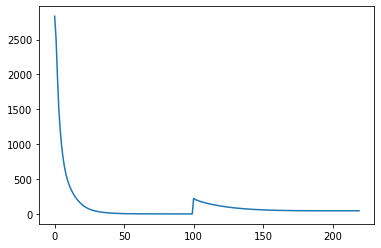

In [45]:
x_values = range(len(train_loss))
plt.plot(x_values, train_loss, label='Train_loss')

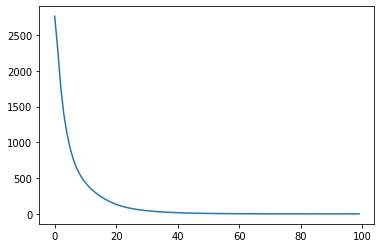

In [46]:
x_values_val = range(len(val_loss))
plt.plot(x_values_val, val_loss, label='val_loss')

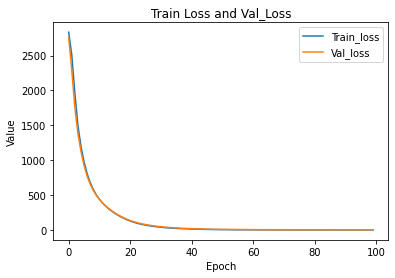

In [47]:
min_length = min(len(train_loss), len(val_loss))
list1 = train_loss[:min_length]
list2 = val_loss[:min_length]

# Create x-axis values
x_values = range(min_length)

# Plot the lists
plt.plot(x_values, list1, label='Train_loss')
plt.plot(x_values, list2, label='Val_loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Train Loss and Val_Loss')
plt.legend()